In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer, AdagradOptimizer, GradientDescentOptimizer, AdamOptimizer, MomentumOptimizer
from pennylane.templates import AmplitudeEmbedding, AngleEmbedding
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

## Data

In [5]:
X, Y = load_iris(return_X_y=True)

#Only First Hundred to Differentiate b/w 2 classes [0, 1], 100+ = more classes
X = X[:100]
Y = Y[:100]

#Split and view data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
print(X[0], Y[0])

[5.1 3.5 1.4 0.2] 0


In [6]:
def drawData(i, j):
    plt.scatter(X[:, i][Y == 1], X[:, j][Y == 1], c="b", marker="o", edgecolors="k")
    plt.scatter(X[:, i][Y == 0], X[:, j][Y == 0], c="r", marker="o", edgecolors="k")
    plt.title("Original data: Property " + str(i+1) + " w/ Property " + str(j+1))

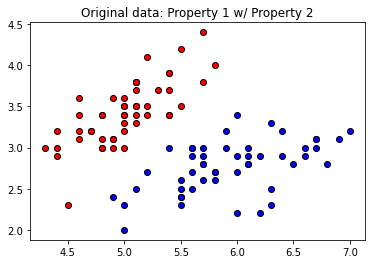

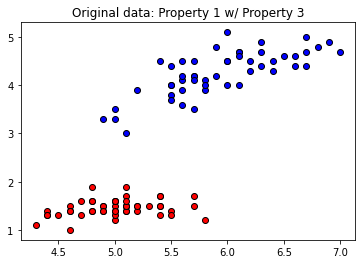

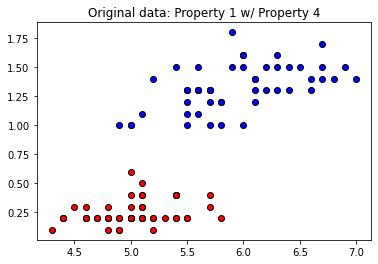

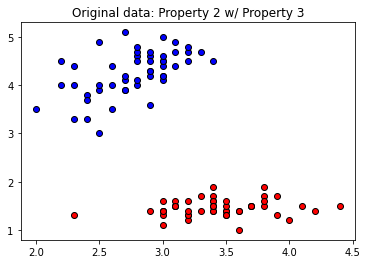

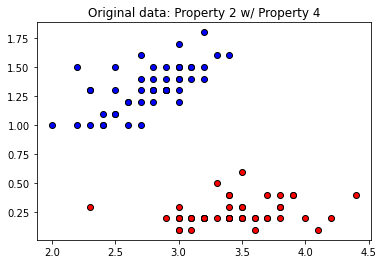

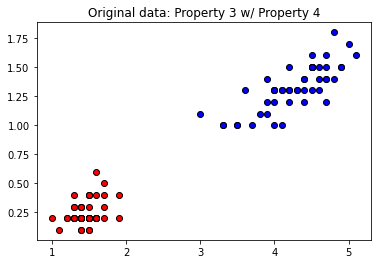

In [7]:
for i in range(3):
    for j in range(i+1, 4):
        plt.figure()
        drawData(i, j)
        plt.show()

## Quantum Circuit

In [8]:
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

In [9]:
#Variational Ansatz
def layer(W):
    qml.adjoint(qml.QFT)(wires=[0, 1])
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.QFT(wires=[0, 1])

In [10]:
@qml.qnode(dev)
def circuit(weights, params):
    #Try Angle Embedding w/ 4 Qubits
    AmplitudeEmbedding(params, wires=range(n_qubits), normalize=True)
    for W in weights:
        layer(W)
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

In [11]:
num_layers = 2 #more layers = more malleable to diverse/exotic data classification
var_init = (0.01 * np.random.randn(num_layers, n_qubits, 3), 0.0)
circuit(var_init[0], X[0]) #0 or 1

tensor(0.48226437, requires_grad=True)

In [12]:
print("x        : ", X[0])
print("angles   : ", AmplitudeEmbedding(X[0], wires=range(n_qubits), normalize=True))
print("amp. vect: ", np.real(dev.state))

x        :  [5.1 3.5 1.4 0.2]
angles   :  AmplitudeEmbedding(array([0.80377277+0.j, 0.55160877+0.j, 0.22064351+0.j, 0.0315205 +0.j]), wires=[0, 1])
amp. vect:  [0.80510275 0.11188235 0.39148636 0.29353056]


## Cost

In [13]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

def accuracy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)
    return loss

In [14]:
def variational_classifier(var, params):
    weights = var[0]
    bias = var[1]
    return circuit(weights, params) + bias


def cost(weights, features, labels):
    predictions = [variational_classifier(weights, f) for f in features]
    return square_loss(labels, predictions)

## Optimizer

In [15]:
np.random.seed(71)
num_layers = 12
var_init = (0.01 * np.random.randn(num_layers, n_qubits, 3), 0.0)

In [16]:
opt = NesterovMomentumOptimizer(0.01) #Parameter Shift Rule, Gradient Descent
batch_size = 5

def signer(inp, threshold):
    if inp >= 0.5 + threshold:
        return 1
    elif inp < 0.5 - threshold:
        return 0
    else:
        return 0.5
def predictor(f, threshold):
    return signer(float(variational_classifier(var, f)), threshold)



var = var_init
threshold = 0
def displayTest(current):
    print("")
    for i in range(10):
        threshold = i*0.05
        predictions_train = [predictor(f, threshold) for f in X_train]
        # Compute accuracy on train set
        acc_train = accuracy(Y_train, predictions_train)
        print(current + ": | Acc train: {:0.7f} | Threshold {:0.5f}" "".format(acc_train, threshold))
    print("")
displayTest("Start")

# train the variational classifier
for it in range(101):
    #Batch Training
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_train_batch = X_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    var = opt.step(lambda v: cost(v, X_train_batch, Y_train_batch), var)

    
    if ((it + 1) % 5 == 0 or it == 0):
        # Compute predictions on train set
        predictions_train = [predictor(f, threshold) for f in X_train]
        # Compute accuracy on train set
        acc_train = accuracy(Y_train, predictions_train)
        theacc = cost(var, X_train_batch, Y_train_batch)
        print("Iter: {:5d} | Cost: {:0.5f} | Acc train: {:0.7f} | Threshold {:0.5f}" "".format(it + 1, theacc*10, acc_train, threshold))
        if (acc_train > 0.70):
            if (threshold < 0.3):
                threshold += 0.05
            else:
                threshold += 0.01
            
displayTest("Results")
        


Start: | Acc train: 0.4266667 | Threshold 0.00000
Start: | Acc train: 0.2000000 | Threshold 0.05000
Start: | Acc train: 0.0400000 | Threshold 0.10000
Start: | Acc train: 0.0000000 | Threshold 0.15000
Start: | Acc train: 0.0000000 | Threshold 0.20000
Start: | Acc train: 0.0000000 | Threshold 0.25000
Start: | Acc train: 0.0000000 | Threshold 0.30000
Start: | Acc train: 0.0000000 | Threshold 0.35000
Start: | Acc train: 0.0000000 | Threshold 0.40000
Start: | Acc train: 0.0000000 | Threshold 0.45000

Iter:     1 | Cost: 3.58159 | Acc train: 0.4533333 | Threshold 0.00000
Iter:     5 | Cost: 2.60023 | Acc train: 0.5466667 | Threshold 0.00000
Iter:    10 | Cost: 1.61190 | Acc train: 1.0000000 | Threshold 0.00000
Iter:    15 | Cost: 0.64172 | Acc train: 1.0000000 | Threshold 0.05000
Iter:    20 | Cost: 0.46556 | Acc train: 1.0000000 | Threshold 0.10000
Iter:    25 | Cost: 0.34042 | Acc train: 1.0000000 | Threshold 0.15000
Iter:    30 | Cost: 0.67600 | Acc train: 0.9333333 | Threshold 0.20000
I

In [22]:
#Number of Errors & Compare VQC to Actual
for i in range(len(X)):
    #if (predictor(X[i], 0.2) - Y[i] != 0):
    #    print(i)
    #print(signer(float(variational_classifier(var, X[i])), 0.25), "\t", Y[i])
    #print(float(variational_classifier(var, X[i]))*100, "\t", Y[i])
    pass

## Plot Training Data vs. Test Data

In [23]:
def plotter(i, j, threshold):
    plt.figure()
    cm = plt.cm.RdBu
    thecomputationTrain = np.array([predictor(i, threshold) for i in X_train])
    thecomputationTest = np.array([predictor(i, threshold) for i in X_test])
    # plot data
    #Train Data - Certain Data
    plt.scatter(
        X_train[:, i][thecomputationTrain == 1],X_train[:, j][thecomputationTrain == 1],
        c="b",marker="o",edgecolors="k",label="class 1 train",
    )
    plt.scatter(
        X_train[:, i][thecomputationTrain == 0],X_train[:, j][thecomputationTrain == 0],
        c="r",marker="o",edgecolors="k",label="class 0 train",
    )
    #Train Data - Uncertain Data
    plt.scatter(
        X_train[:, i][thecomputationTrain == 0.5],X_train[:, j][thecomputationTrain == 0.5],
        c="y",marker="o",edgecolors="k",label="class ? train",
    )
    
    #Test Data - Certain Data
    plt.scatter(
        X_test[:, i][thecomputationTest == 1],X_test[:, j][thecomputationTest == 1],
        c="b",marker="^",edgecolors="k",label="class 1 test",
    )
    plt.scatter(
        X_test[:, i][thecomputationTest == 0],X_test[:, j][thecomputationTest == 0],
        c="r",marker="^",edgecolors="k",label="class 0 test",
    )
    #Test Data - Uncertain Data
    plt.scatter(
        X_test[:, i][thecomputationTest == 0.5],X_test[:, j][thecomputationTest == 0.5],
        c="y",marker="^",edgecolors="k",label="class ? test",
    )
    
    plt.legend()
    return plt

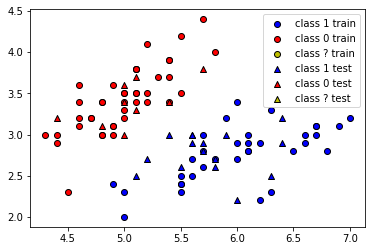

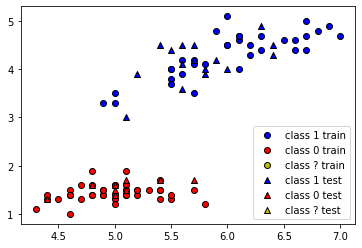

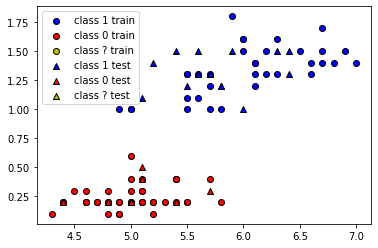

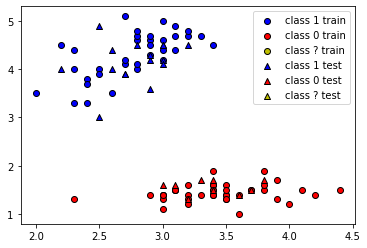

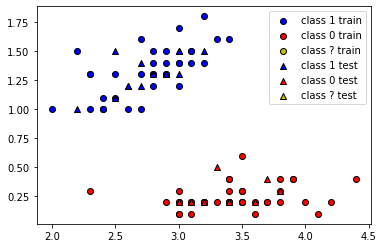

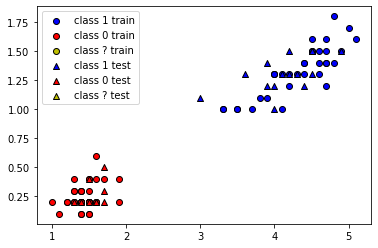

In [25]:
for i in range(3):
    for j in range(i+1, 4):
        plotter(i, j, 0.2) #x < 25 -> 0        x > 75 -> 1
        #plotter(i, j, 0.35) #x < 15 -> 0        x > 85 -> 1
        plt.show()